In [1]:
"""Bayesian Estimation Supersedes the T-Test

This model replicates the example used in:
Kruschke, John. (2012) Bayesian estimation supersedes the t test. Journal of Experimental Psychology: General.

The original pymc2 implementation was written by Andrew Straw and can be found here: https://github.com/strawlab/best

Ported to PyMC3 by Thomas Wiecki (c) 2015.
"""

import numpy as np
import pymc3 as pm

drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = np.concatenate((y1, y2))

mu_m = np.mean( y )
mu_p = 0.000001 * 1/np.std(y)**2

sigma_low = np.std(y)/1000
sigma_high = np.std(y)*1000

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=mu_m, tau=mu_p, testval=y1.mean())
    group2_mean = pm.Normal('group2_mean', mu=mu_m, tau=mu_p, testval=y2.mean())
    group1_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high, testval=y1.std())
    group2_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high, testval=y2.std())
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1
    
    lam1 = group1_std**-2
    lam2 = group2_std**-2

    group1 = pm.T('drug', nu=nu, mu=group1_mean, lam=lam1, observed=y1)
    group2 = pm.T('placebo', nu=nu, mu=group2_mean, lam=lam2, observed=y2)

    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / pm.sqrt((group1_std**2 + group2_std**2) / 2))
    
    step = pm.NUTS()
    trace = pm.sample(5000, step)

 [-----------------100%-----------------] 5000 of 5000 complete in 42.3 sec

/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [2]:
%matplotlib inline

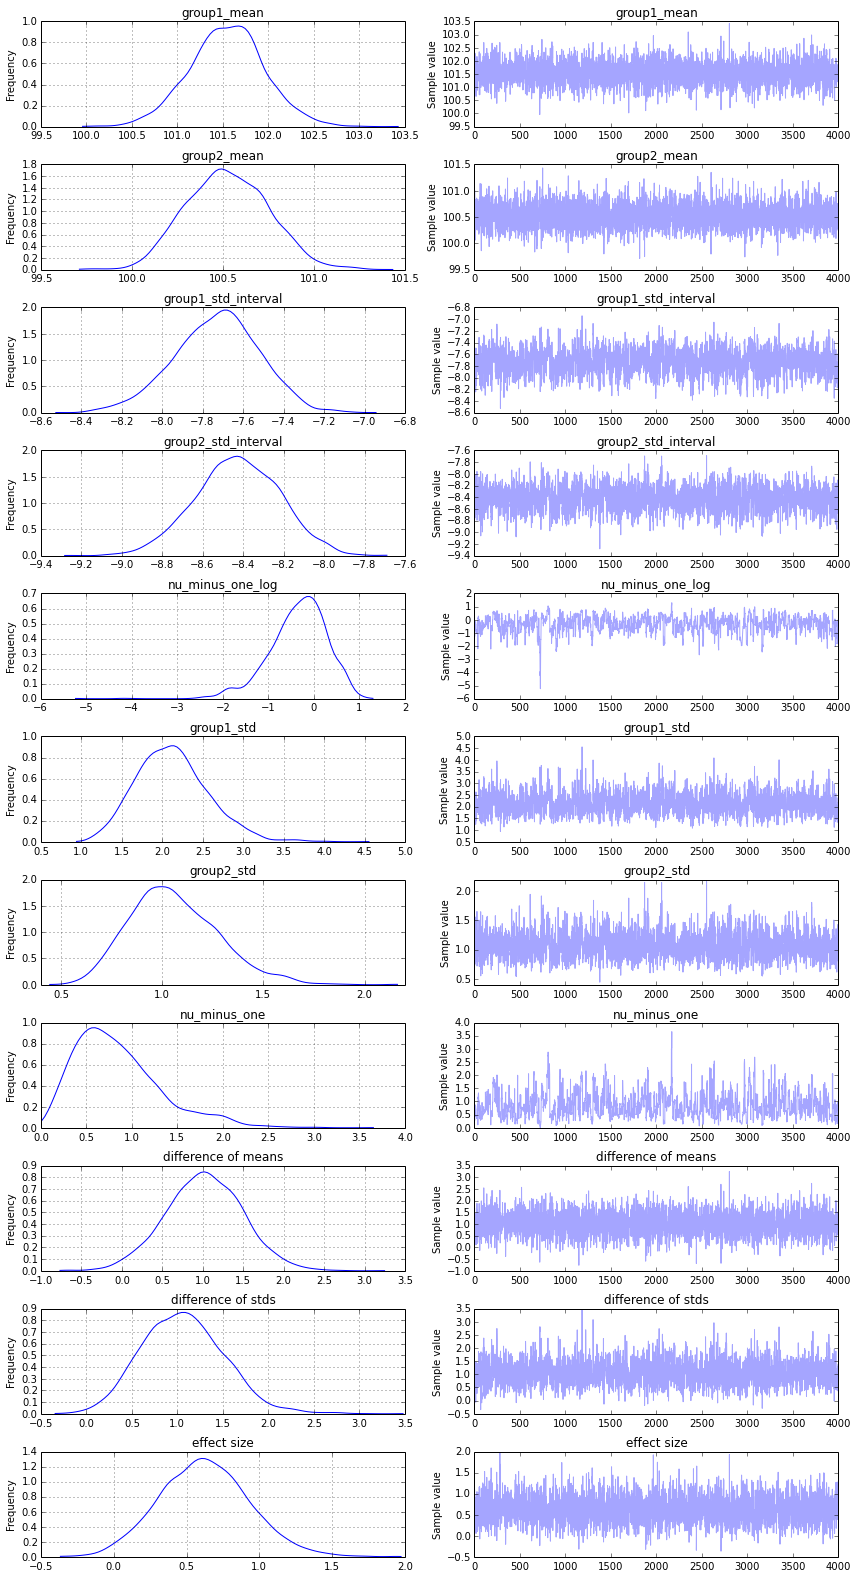

In [3]:
pm.traceplot(trace[1000:]);

In [4]:
pm.plots.summary(trace[1000:])


group1_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  101.545          0.414            0.007            [100.749, 102.385]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  100.713        101.275        101.550        101.813        102.365


group2_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  100.526          0.226            0.003            [100.111, 100.953]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  100.116        100.368        100.518        100.682        100.966


group1_std_interval:

  Mean             SD               MC Error         95% HP